# Title to go here

## Environment Setup Instructions (macOS / Linux)

Follow the instructions below to create a virtual environment, install required packages, and register the notebook kernel.

Open a terminal and run the following:

```bash
cd /path to the mnk_transformer folder          # Navigate to the folder containing this notebook
chmod +x setup.sh                               # Make the script executable (only needed once)
./setup.sh                                      # Run the setup script


After the script finishes...
1. Reopen this notebook (or restart the current VS Code window).
2. In the top-right corner, click the kernel selector.
3. Choose the kernel named: `Python (TicTacToe)`

Then, run the cell below, and you’re ready to run the notebook!

In [1]:
import functions_for_thesis_display as f
from play_against_gpt import play_game
from setup import load_from_checkpoint
model = load_from_checkpoint()

## Introduction

### How do we think about GPTs?
Your writing will be here.

### What are my research questions?
Your writing will be here.

### What concrete questions will we ask?
Your writing will be here.

In [2]:
play_game(model)

## Model Originality

We've seen above that the trained model can successfully play a game of tic-tac-toe. But how does it do that? Might it just be memorizing the games we showed it as it trained, and repeating them back exactly? This would be bad, especially when we think about language models! What if ChatGPT could only regurgitate exact writing that it had seen before? These models are only useful if they can generate novel games (or text!), so we test this capability.

To test the model's creativity, we train the model on 100,000 synthetically generated games of tic-tac-toe. These games are created by randomly choosing a move for players until one player wins or the board is filled. Then, once the model is trained, we ask it to generate 1,000 games and track how many of these games were included in the synthetic training dataset. We compute an originality score as follows.

$$
\text{Originality Score} = 1 - \frac{\text{\# of generated games present in training dataset}}{\text{total \# of games generated}}
$$

There are 255,168 possible games of Tic-Tac-Toe, so we would expect originality scores around<sup>[1]</sup>

$$
\frac{255,\!168 - 100,\!000}{255,\!168} \approx 60.8\%
$$



<p><sup>[1]</sup> <small><em>We would actually expect an originality score slightly higher than 60.8%, because the synthetic games are randomly generated, and can include overlapping games. A dataset with 100,000 elements is highly unlikely to have 100,000 distinct elements, but this is an expected floor for our originality score.</em></small></p>


## Learning the Rules of the Game

This section explores how the GPT model begins to pick up on the fundamental rules of tic tac toe through exposure to examples. We aim to understand whether the model is learning strategies or simply memorizing board states.

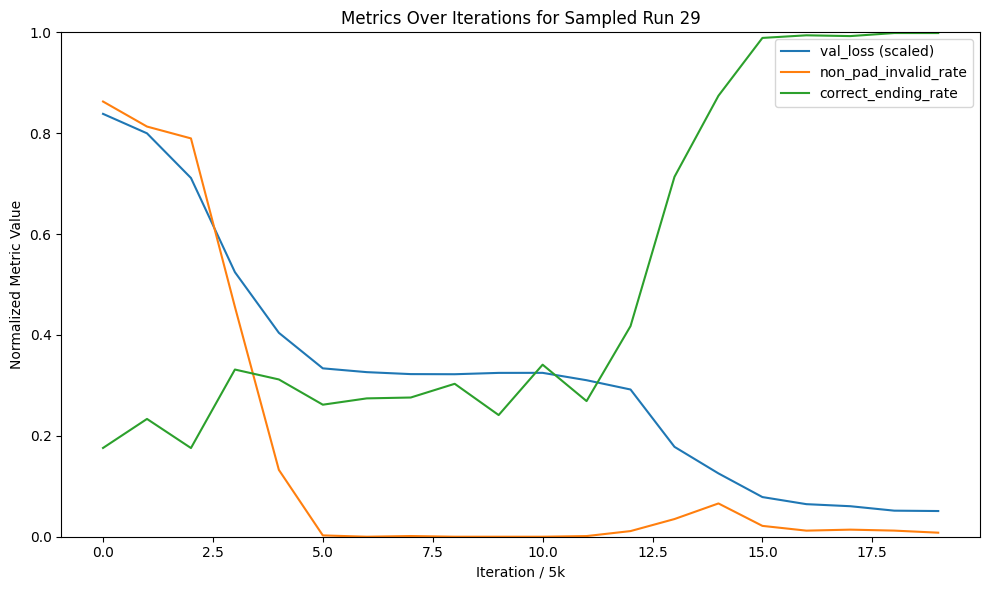

In [3]:
f.display_random_training_run()

## Internal Representation of the Game

### Different Tasks to Test
Your writing will be here.

### Linear vs. Nonlinear
Your writing will be here.


### Change in Number of Heads
Your writing will be here.

## Conclusion

### Summary of Findings
Your writing will be here.

### Future Work
Your writing will be here.

## Appendix

### Parameter Allocation
Your writing will be here.

### Math of GPT

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right)V
$$

### Mechanistic Interpretability Lit Review
Your writing will be here.